In [ ]:
# libraries
import swifter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter

# text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# topic modeling
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary

# initialize global variables
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# download nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

### Dynamic Topic Modeling 

#### Weekly

In [37]:
# read csv
comments = pd.read_csv('../data/processed/comments.csv')
# sort by date
comments = comments.sort_values(by='datetime')
# drop rows with missing values
comments = comments.dropna()
comments = comments.reset_index(drop=True)
comments['date_day'] = pd.to_datetime(comments['date_day'])

comments


,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day
0,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who...",2024-06-01
1,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01
2,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...,2024-06-01
3,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...,2024-06-01
4,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...,2024-06-01
...,...,...,...,...,...,...,...,...,...
167794,politics,t3_1gjdfxd,t1_lvfrzmk,t1_lvfrjhp,2024-11-05 00:58:37,7,7,"Trump up 4 points in Maryland!\n\n(""See? That ...",2024-11-05
167795,politics,t3_1gjdfxd,t1_lvfs1gu,t3_1gjdfxd,2024-11-05 00:58:54,12,12,"At this point the only states im ""worried"" abo...",2024-11-05
167796,politics,t3_1gjdfxd,t1_lvfs1k6,t1_lvfre42,2024-11-05 00:58:55,-5,-5,He's been saying the same script for the past ...,2024-11-05
167797,Conservative,t3_1gjrpbw,t1_lvfs3rk,t1_lvfqjvl,2024-11-05 00:59:17,49,49,This is the same county that the court case fo...,2024-11-05


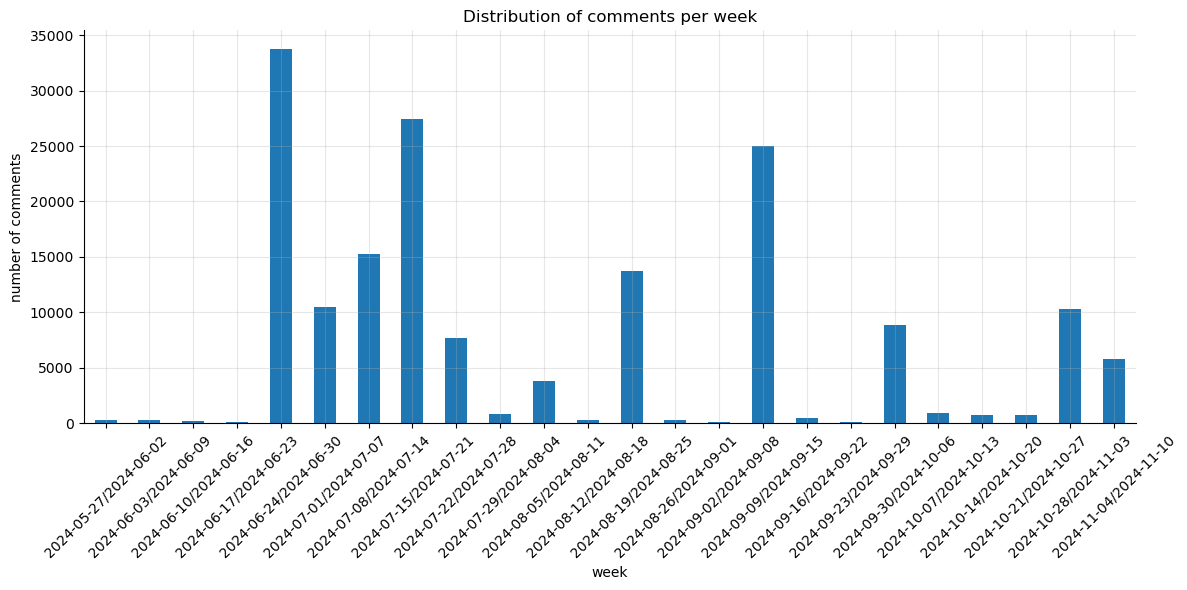

In [ ]:
# plot distribution of comments per week
plt.figure(figsize=(12, 6))
comments['date_day'].dt.to_period('W').value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of comments per week')
plt.xlabel('week')
plt.ylabel('number of comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
comments['week'] = comments['date_day'].dt.to_period('W')
sample_values = min(comments['week'].value_counts().sort_index())
sample_values

85

In [ ]:
# from each week, get random sample of 85 comments
comments_sample = comments.groupby('week').apply(lambda x: x.sample(sample_values)).reset_index(drop=True)
comments_sample = comments_sample.sort_values(by='datetime')
comments_sample

C:\Users\bnvul\AppData\Local\Temp\ipykernel_10152\4004539867.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comments_sample = comments.groupby('week').apply(lambda x: x.sample(85)).reset_index(drop=True)


,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day,week
31,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01,2024-05-27/2024-06-02
6,Conservative,t3_1d5divx,t1_l6ksnhq,t3_1d5divx,2024-06-01 05:55:10,18,18,A whole month? Didn't Pedo Joe just give them ...,2024-06-01,2024-05-27/2024-06-02
37,politics,t3_1d5ov0s,t1_l6mv0xy,t3_1d5ov0s,2024-06-01 17:14:25,21,21,R.J. Matson:\n \n[Trump felony convictionsouve...,2024-06-01,2024-05-27/2024-06-02
69,politics,t3_1d5ov0s,t1_l6mvnto,t3_1d5ov0s,2024-06-01 17:18:22,13,13,Fiona Katauskas:\n \n[The bestest!](,2024-06-01,2024-05-27/2024-06-02
27,politics,t3_1d5ov0s,t1_l6n421l,t1_l6mv2n4,2024-06-01 18:09:00,16,16,">Their Duty.\n\nJurors, as well as the judge a...",2024-06-01,2024-05-27/2024-06-02
...,...,...,...,...,...,...,...,...,...,...
2037,politics,t3_1gjdfxd,t1_lvfd5p2,t3_1gjdfxd,2024-11-04 23:36:50,11,11,Megyn MAGA SELLOUT Kelly is going to be at a T...,2024-11-04,2024-11-04/2024-11-10
2018,politics,t3_1gjdfxd,t1_lvffv4y,t1_lvfenrg,2024-11-04 23:51:39,2,2,Is Trump not also a war criminal,2024-11-04,2024-11-04/2024-11-10
1973,politics,t3_1gjdfxd,t1_lvfh2zg,t1_lvfgrqg,2024-11-04 23:58:16,1,1,"That's my thinking too. Biden, for all his suc...",2024-11-04,2024-11-04/2024-11-10
2027,politics,t3_1gjdfxd,t1_lvfoatr,t3_1gjdfxd,2024-11-05 00:38:01,25,25,"So legit question, something that I think the ...",2024-11-05,2024-11-04/2024-11-10


#### Biweekly

In [78]:
# read csv
comments = pd.read_csv('../data/processed/comments.csv')
# sort by date
comments = comments.sort_values(by='datetime')
# drop rows with missing values
comments = comments.dropna()
comments = comments.reset_index(drop=True)
comments['date_day'] = pd.to_datetime(comments['date_day'])

comments

,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day
0,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who...",2024-06-01
1,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01
2,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...,2024-06-01
3,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...,2024-06-01
4,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...,2024-06-01
...,...,...,...,...,...,...,...,...,...
167794,politics,t3_1gjdfxd,t1_lvfrzmk,t1_lvfrjhp,2024-11-05 00:58:37,7,7,"Trump up 4 points in Maryland!\n\n(""See? That ...",2024-11-05
167795,politics,t3_1gjdfxd,t1_lvfs1gu,t3_1gjdfxd,2024-11-05 00:58:54,12,12,"At this point the only states im ""worried"" abo...",2024-11-05
167796,politics,t3_1gjdfxd,t1_lvfs1k6,t1_lvfre42,2024-11-05 00:58:55,-5,-5,He's been saying the same script for the past ...,2024-11-05
167797,Conservative,t3_1gjrpbw,t1_lvfs3rk,t1_lvfqjvl,2024-11-05 00:59:17,49,49,This is the same county that the court case fo...,2024-11-05


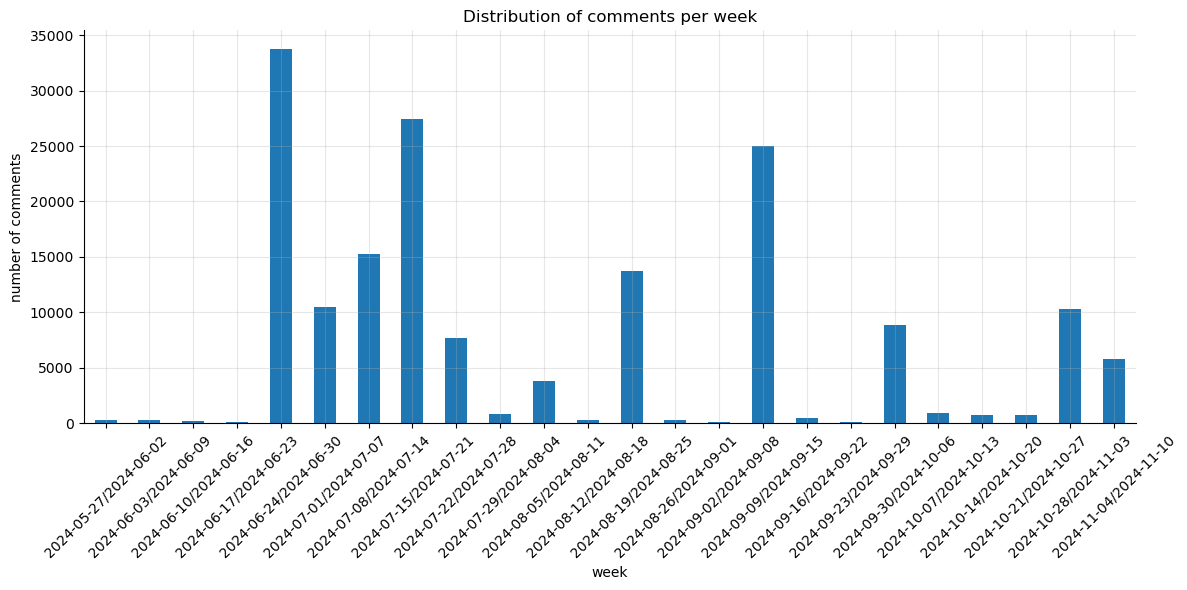

In [79]:
plt.figure(figsize=(12, 6))
comments['date_day'].dt.to_period('W').value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of comments per week')
plt.xlabel('week')
plt.ylabel('number of comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [80]:
#make the column date_day the index
biweekly_comments = comments.set_index('date_day', inplace=False)
sample_values = min(biweekly_comments.groupby(pd.Grouper(freq='2W'))['body'].count().sort_index())
sample_values

327

In [84]:
comments_sample = biweekly_comments.groupby(pd.Grouper(freq='2W')).apply(lambda x: x.sample(sample_values)).reset_index(drop=True)
comments_sample = comments_sample.sort_values(by='datetime')
comments_sample['datetime'] = pd.to_datetime(comments_sample['datetime'])
comments_sample

,subreddit,post_id,id,parent,datetime,score,upvotes,body
235,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who..."
135,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.
67,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...
1,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...
9,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...
...,...,...,...,...,...,...,...,...
3969,politics,t3_1gjdfxd,t1_lvfqq2x,t3_1gjdfxd,2024-11-05 00:51:27,14,14,"[\n\nTitle: 'In my humble view, lights out’: N..."
4243,politics,t3_1gjdfxd,t1_lvfqz6s,t3_1gjdfxd,2024-11-05 00:52:53,-8,-8,I'm in Australia and the bookmakers have Trump...
4230,politics,t3_1gjdfxd,t1_lvfr9ja,t3_1gjdfxd,2024-11-05 00:54:30,2,2,Anyone watching the Trump rally? I feel like h...
4109,politics,t3_1gjdfxd,t1_lvfr9p4,t3_1gjdfxd,2024-11-05 00:54:32,11,11,McCormick telling people to tell ten friends t...


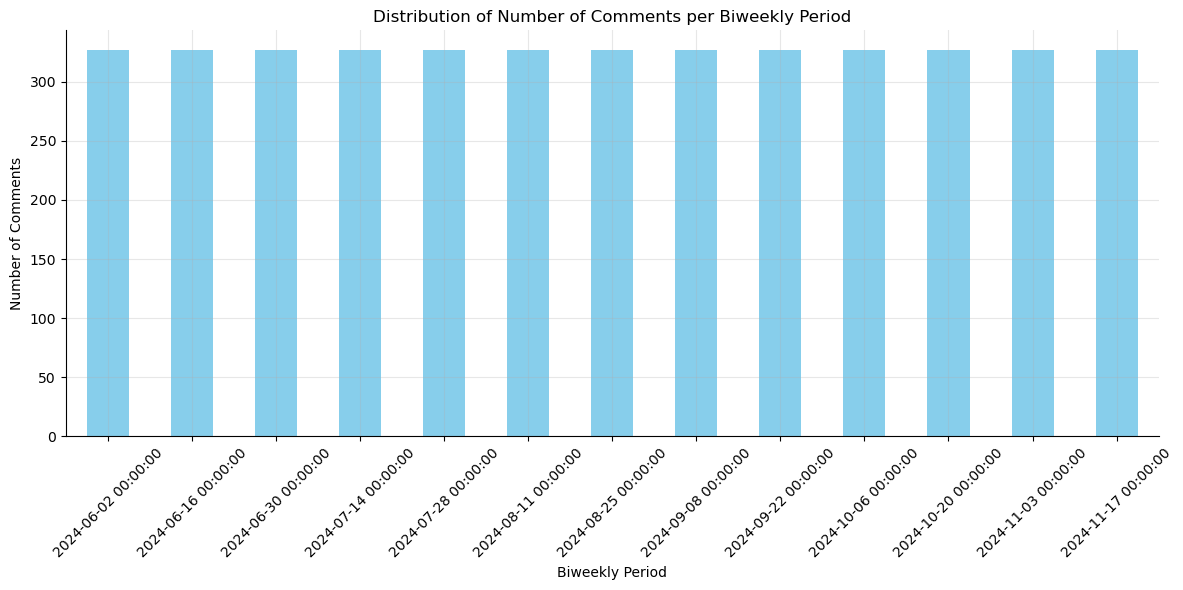

In [85]:
# Group by biweekly periods and count the number of comments in each period
biweekly_counts = comments_sample.set_index('datetime', inplace=False).groupby(pd.Grouper( freq='2W')).size()

# Plotting the distribution
plt.figure(figsize=(12, 6))
biweekly_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Number of Comments per Biweekly Period')
plt.xlabel('Biweekly Period')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [88]:
biweekly_counts

datetime
2024-06-02    327
2024-06-16    327
2024-06-30    327
2024-07-14    327
2024-07-28    327
2024-08-11    327
2024-08-25    327
2024-09-08    327
2024-09-22    327
2024-10-06    327
2024-10-20    327
2024-11-03    327
2024-11-17    327
Freq: 2W-SUN, dtype: int64

#### modeling

In [87]:
def preprocess_text(text):
    """
    Preprocess text for topic modeling.
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # lowercase
    text = text.lower()

    # delete special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # tokenize
    tokens = word_tokenize(text)

    # delete stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens
             if token not in stop_words and len(token) > 2]

    return tokens


# Aplicar preprocesamiento
comments_sample['processed_text'] = comments_sample['body'].swifter.apply(preprocess_text)

# Verificar el preprocesamiento
print("\nResults:")
print("Original:", comments_sample['body'].iloc[0])
print("Processed:", comments_sample['processed_text'].iloc[0])

Pandas Apply:   0%|          | 0/4251 [00:00<?, ?it/s]


Results:
Original: Bragg a commie? Nah, he's just a sycophant who will go along with whatever the Jackass party wants him to say. Biden says "Convict his political rival", Bragg says "For how long?".
Processed: ['bragg', 'commie', 'nah', 'he', 'sycophant', 'along', 'whatever', 'jackass', 'party', 'want', 'say', 'biden', 'say', 'convict', 'political', 'rival', 'bragg', 'say', 'long']


In [92]:
# create dictionary
dictionary = Dictionary(comments_sample['processed_text'])

# filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nVocabulary size:", len(dictionary))

# create corpus
corpus = [dictionary.doc2bow(doc) for doc in comments_sample['processed_text']]

# prepare time slices
# for weekly periods
# time_slices = comments_sample.groupby('week').size().tolist()

# for biweekly periods
time_slices = comments_sample.set_index('datetime', inplace=False).groupby(pd.Grouper( freq='2W')).size().tolist()


print("\nNumber of time periods:", len(time_slices))



Vocabulary size: 2623

Number of time periods: 13


In [93]:
# train LDA model
num_topics = 5  # number of topics
chain_variance = 0.100  # control how much the topics change over time

dtm = LdaSeqModel(
    corpus=corpus,
    time_slice=time_slices,
    num_topics=num_topics,
    id2word=dictionary,
    chain_variance=chain_variance,
    passes=10
)

c:\Users\bnvul\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\bnvul\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
c:\Users\bnvul\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\bnvul\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\bnvul\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * t

In [94]:
def print_topic_evolution(model, periods=None):
    """
    print the evolution of topics over time
    """
    num_time_slices = len(time_slices)
    for t in range(num_time_slices):
        print(f"\nPeríodo {t}:")
        for topic in range(model.num_topics):
            top_terms = model.print_topics(time=t)[topic]
            print(f"Tópico {topic}: {top_terms[:5]}")

# show topic evolution
print_topic_evolution(dtm)


Período 0:
Tópico 0: [('crime', 0.019671287650340156), ('law', 0.011125276497790536), ('case', 0.008481502304114175), ('judge', 0.008235705370756106), ('campaign', 0.008002974888013464)]
Tópico 1: [('biden', 0.04623028344185236), ('like', 0.02568467722772089), ('get', 0.014261255321468153), ('he', 0.013375636211138544), ('dont', 0.013073543123679735)]
Tópico 2: [('people', 0.02649016289532746), ('conservative', 0.015912697708640997), ('think', 0.012765897881018912), ('like', 0.011146157254790666), ('dont', 0.010369661887991575)]
Tópico 3: [('policy', 0.021004260166649087), ('democrat', 0.018127756224535503), ('biden', 0.014096871066884753), ('republican', 0.013250906014691649), ('state', 0.013092549166891617)]
Tópico 4: [('biden', 0.03141220129657963), ('president', 0.01646690003499422), ('year', 0.013410197161967239), ('country', 0.010151262671509726), ('office', 0.009727423183944473)]

Período 1:
Tópico 0: [('paxton', 0.01260959066412865), ('crime', 0.010029738792232597), ('would', 

In [ ]:
 
'''
1. Parameter Setting:
   - Modify num_topics and observe the changes.
   - Experiment with different chain_variance.
   - Try different temporal granularities
2. Temporal Analysis:
   - How do topics change?
   - Are there specific events that affect topics?
   - Which categories are most stable/variable?
3. Additional Visualizations:
   - Create a heatmap of temporal evolution.
   - Visualize the similarity between topics
   - Graph the evolution of specific categories
4. Preprocessing:
   - Adds/removes stopwords
   - Include bigraphs
   - Modify frequency filters
'''

'\n1. Parameter Setting:\n   - Modify num_topics and observe the changes.\n   - Experiment with different chain_variance.\n   - Try different temporal granularities\n2. Temporal Analysis:\n   - How do topics change month to month?\n   - Are there specific events that affect topics?\n   - Which categories are most stable/variable?\n3. Additional Visualizations:\n   - Create a heatmap of temporal evolution.\n   - Visualize the similarity between topics\n   - Graph the evolution of specific categories\n4. Preprocessing:\n   - Adds/removes stopwords\n   - Include bigraphs\n   - Modify frequency filters\n'

In [95]:
# save model
dtm.save('dtm_model_5topics_0_100chanin_biweekly')

# export topics evolution
topics_over_time = {}
num_time_slices = len(time_slices)

for t in range(num_time_slices):
    # obtain topics
    topics = dtm.print_topics(time=t)

    # save topics
    period_topics = {}
    for topic_id, topic_terms in enumerate(topics):
        period_topics[f'Topic_{topic_id}'] = topic_terms[:5] 

    topics_over_time[t] = period_topics

# dataframe
topics_df = pd.DataFrame.from_dict(topics_over_time, orient='index')

# save to csv
topics_df.to_csv('../data/mining/model_5topics_0_100chanin_biweekly.csv')
